## SBBGCA usage
Usage of SBBGCA.ipynb

In [1]:
# do clustering and output two pickle files. (@_intermediate.pickle and @_nameDict.pickle)
% run SBBGCA.ipynb

data_directory = "hooklogs/allaple_woj_g_98/"
tag = "allaple_woj_g_98"  # used for pickle name
outputPath = "output/SBBGCA_Clustering/allaple_woj_g_98/"

if not os.path.isdir(outputPath): os.makedirs(outputPath) # create output path Directory
    
intermediatePool, initialNames = do_SBBGCA_clustering(data_directory, tag, outputPath)

# saving intermediatePool as pickle file
if not os.path.isdir(outputPath): os.makedirs(outputPath)
with open(outputPath + tag + '_intermediate.pickle', 'wb') as handle:
    pickle.dump(intermediatePool, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving initialNames dict as pickle file
with open(outputPath + tag + '_nameDict.pickle', 'wb') as handle:
    pickle.dump(initialNames, handle, protocol=pickle.HIGHEST_PROTOCOL)

-- Finish Initializing --
-- Start Clustering --
-- Finish Clustering --


In [2]:
# read pickle files

import pickle

with open(outputPath + tag + '_intermediate.pickle', 'rb') as handle:
    intermediate = pickle.load(handle)

with open(outputPath + tag + '_nameDict.pickle', 'rb') as handle:
    nameDict = pickle.load(handle)
print(nameDict)

{'G0': '0316c4_3320', 'G1': '08d0f7_3308', 'G2': '245b08_3284', 'G3': '28efa1_3272', 'G4': '2fbc8c_3284', 'G5': '31260c_3176', 'G6': '329d35_3328', 'G7': '329d35_3384', 'G8': '405c75_3248', 'G9': '4ab715_3208', 'G10': '4b9f98_3056', 'G11': '6546cc_3184', 'G12': '6f73aa_3392', 'G13': '73d1ab_3260', 'G14': '7a28c0_3208', 'G15': '802d6c_3300', 'G16': '8d2207_3344', 'G17': '9f8b03_3408', 'G18': 'a3a37b_3332', 'G19': 'aa634c_3232', 'G20': 'b04e89_3176', 'G21': 'b60814_2840', 'G22': 'b71a4a_3256', 'G23': 'bd9a4b_3400', 'G24': 'bdf002_3304', 'G25': 'c6d288_3216', 'G26': 'd4743b_3304', 'G27': 'd6d1ed_3360', 'G28': 'e0428e_3252', 'G29': 'e26147_3260', 'G30': 'fb4273_3224', 'G31': 'fe7658_3224'}


In [3]:
# reverse clusterID by hooklogName

def findClusterID(nameDict, hooklogName):
    for key, value in nameDict.items():
        if(value == hooklogName):
            return key
    return hooklogName

In [4]:
# convert memberSet to List type

def getMemberList(memberSet):
    memberList = list()
    while(len(memberSet)>0):
        member = memberSet.pop()
        clusterID = findClusterID(nameDict, member)
        memberList.append(clusterID)
    return memberList

In [5]:
# z[0] = g1,  z[1] = g2,  z[2] = 高度
# Create Z

import numpy as np

Z = np.zeros((len(intermediate) ,4))

# create Z
iterCounter = 0
for key, value in intermediate.items():
    score = value[0]
    height = 1 - score
    clusterName = value[1][0]
    memberSet = value[2] # members set
    
    memberList = getMemberList(memberSet)
    print(memberList)
    member1 = memberList[0][1::]
    member2 = memberList[1][1::]
    
    Z[iterCounter] = [member1, member2, height, len(memberList)] # set Z element
    iterCounter+=1

['G1', 'G0']
['G23', 'G2']
['G3', 'G11']
['G5', 'G4']
['G6', 'G7']
['G8', 'G10']
['G12', 'G13']
['G14', 'G20']
['G26', 'G15']
['G21', 'G36']
['G22', 'G24']
['G25', 'G34']
['G27', 'G28']
['G29', 'G30']
['G32', 'G31']
['G35', 'G37']
['G38', 'G39']
['G44', 'G42']
['G45', 'G46']
['G48', 'G47']
['G49', 'G50']
['G51', 'G52']
['G19', 'G9']
['G40', 'G33']
['G43', 'G54']
['G56', 'G53']
['G57', 'G55']
['G58', 'G17']
['G59', 'G41']
['G16', 'G18']
['G61', 'G60']


In [6]:
def createLabelList(nameDict):
    dict_keys = list(nameDict.keys())
    dict_keys.sort(key=lambda tup:tup[1::])
    
    labelList = list()
    for key in dict_keys:
        labelList.append( nameDict[key] )
    
    return labelList

['0316c4_3320', '08d0f7_3308', '4b9f98_3056', '6546cc_3184', '6f73aa_3392', '73d1ab_3260', '7a28c0_3208', '802d6c_3300', '8d2207_3344', '9f8b03_3408', 'a3a37b_3332', 'aa634c_3232', '245b08_3284', 'b04e89_3176', 'b60814_2840', 'b71a4a_3256', 'bd9a4b_3400', 'bdf002_3304', 'c6d288_3216', 'd4743b_3304', 'd6d1ed_3360', 'e0428e_3252', 'e26147_3260', '28efa1_3272', 'fb4273_3224', 'fe7658_3224', '2fbc8c_3284', '31260c_3176', '329d35_3328', '329d35_3384', '405c75_3248', '4ab715_3208']


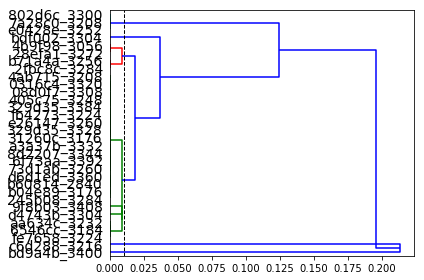

In [7]:
# Draw pic

import scipy
import scipy.cluster.hierarchy as sch
import matplotlib.pylab as plt
%matplotlib inline

upgma_threshold = 0.01 #---input
label_list = createLabelList(nameDict)
print(label_list)

(orig_x, orig_y) = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (6, 4) #---input

# P = sch.dendrogram(Z, color_threshold = upgma_threshold, orientation = 'right') # no label
P = sch.dendrogram(Z, color_threshold = upgma_threshold, labels = label_list, orientation = 'right')

plt.axvline(x=upgma_threshold, linewidth=1, color='black', linestyle='--')
locs, labels = plt.yticks()
# plt.xticks(  np.arange(0,1.1,0.1)) #---Align axis-x 900(0, 0.35, 0.05) 909(0,0.6,0.1) 855(0, 0.9, 0.1)
plt.setp(labels, fontsize = 14)
plt.tight_layout()

plt.rcParams['figure.figsize'] = (orig_x, orig_y)
plt.savefig(outputPath+'SBBGCA_'+tag+'.pdf', dpi=300)